$\Large\textbf{Lab 3.}$ $\large\textbf{Exercise 2.}$



In [1]:
import numpy as np 
from numpy.linalg import cond
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

#method to find Hessian matrix: Complete the code
def evalh(x): 
  assert type(x) is np.ndarray 
  assert len(x) == 2
  return np.array([[-2048*x[1]+6144*x[0]**2+2,-2048*x[0]],[-2048*x[0],1024]])

#method to find the condition number of any square matrix: : Complete the code
def find_condition_number(A):
  assert type(A) is np.ndarray
  assert A.shape[0] == A.shape[1]
  return cond(A)

In [2]:
#The method defines a way to construct D_k matrix used in scaling the gradient in the modified gradient descent scheme
def compute_D_k(x):
  assert type(x) is np.ndarray
  assert len(x) == 2
  #compute and return D_k
  a=1/(evalh(x)[0][0])
  b=1/(evalh(x)[1][1])
  return np.array([[a, 0], [0, b]])


In [3]:
def compute_D_k_newton(x):
    assert type(x) is np.ndarray
    assert len(x) == 2
    
    return np.linalg.inv(evalh(x))

In [4]:
#Now we will define a Python function which will compute and return the objective function value 
def evalf(x):  
  #Input: x is a numpy array of size 2 
  assert type(x) is np.ndarray and len(x) == 2 #do not allow arbitrary arguments 
  #after checking if the argument is valid, we can compute the objective function value
  #compute the function value and return it 
  return (512*(x[1]-x[0]**2)**2 + (4-x[0])**2)


In [5]:
#Now we will define a Python function which will compute and return the gradient value as a numpy array 
def evalg(x):  
  #Input: x is a numpy array of size 2 
  assert type(x) is np.ndarray and len(x) == 2 #do not allow arbitrary arguments 
  #after checking if the argument is valid, we can compute the gradient value
  #compute the gradient value and return it 
  return np.array([-2048*x[0]*(x[1]-x[0]**2)+2*x[0]-8, 1024*(x[1]-x[0]**2)])

In [6]:
#Complete the module to compute the steplength by using the closed-form expression
def compute_steplength_backtracking(x, gradf, alpha_start, rho, gamma, *args): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  #Complete the code 
  alpha = alpha_start
  pk = -gradf
  while evalf(np.add(x, alpha*pk)) > np.add(evalf(x), gamma*alpha*np.dot(gradf.T,pk)):
    alpha = rho*alpha

  return alpha
  

In [7]:
def compute_steplength_backtracking_scaled_direction(x, gradf, direction, alpha_start, rho, gamma, *args): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == 2 
  assert type(gradf) is np.ndarray and len(gradf) == 2 
  assert type(direction) is np.ndarray and len(direction) == 2 
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 
  
  
  
  #Complete the code 
  alpha = alpha_start
  pk = -gradf
  while evalf(np.add(x, alpha*np.dot(direction,pk))) > np.subtract(evalf(x), gamma*alpha*np.dot(np.dot(direction,gradf), gradf)):
    alpha = rho*alpha
  return alpha

In [8]:
#line search type 
EXACT_LINE_SEARCH = 1
BACKTRACKING_LINE_SEARCH = 2
CONSTANT_STEP_LENGTH = 3

In [9]:
# D_k choice type
newton = 4
diagonal_approx = 5

In [10]:
#complete the code for gradient descent to find the minimizer
def find_minimizer_gd(start_x, tol, line_search_type, *args):
    #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
    assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
    assert type(tol) is float and tol>=0 

    x = start_x
    g_x = evalg(x)
    condition_array = [find_condition_number(evalh(x))]

    #initialization for backtracking line search
    if(line_search_type == BACKTRACKING_LINE_SEARCH):
        alpha_start = args[0]
        rho = args[1]
        gamma = args[2]

    k = 0

    while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking(x,g_x, alpha_start,rho, gamma) #call the new function you wrote to compute the steplength
        elif line_search_type == CONSTANT_STEP_LENGTH: #do a gradient descent with constant step length
            step_length = 0.1
        else:  
            raise ValueError('Line search type unknown. Please check!')
        
        #implement the gradient descent steps here   
        x = np.subtract(x, np.multiply(step_length,g_x)) #update x = x - step_length*g_x
        k += 1 #increment iteration
        g_x = evalg(x) #compute gradient at new point
        condition_array.append(find_condition_number(evalh(x)))

    return x, evalf(x), k, condition_array


In [11]:
# Code for gradient descent with scaling to find the minimizer with scaling

def find_minimizer_gdscaling(start_x, tol, line_search_type, D_k_type, *args):
    #Input: start_x is a numpy array of size 2, tol denotes the tolerance and is a positive float value
    assert type(start_x) is np.ndarray and len(start_x) == 2 #do not allow arbitrary arguments 
    assert type(tol) is float and tol>=0 

    x = start_x
    g_x = evalg(x)
    condition_array = []
    
    #initialization for backtracking line search
    alpha_start = args[0]
    rho = args[1]
    gamma = args[2]

    k = 0

    while (np.linalg.norm(g_x) > tol): #continue as long as the norm of gradient is not close to zero upto a tolerance tol
        if D_k_type == newton:
            d_k = compute_D_k_newton(x)
        elif D_k_type == diagonal_approx:
            d_k = compute_D_k(x)
        else:
            raise ValueError("Invalid argument.")


        m = sqrtm(d_k)
        condition_array.append(find_condition_number(np.dot(m.T, np.dot(evalh(x),m))))
        if line_search_type == BACKTRACKING_LINE_SEARCH:
            step_length = compute_steplength_backtracking_scaled_direction(x, g_x, d_k, alpha_start, rho, gamma) #call the new function you wrote to compute the steplength
        else:  
            raise ValueError('Line search type unknown. Please check!')
        
        #implement the gradient descent steps here   
        x = np.subtract(x, np.multiply(step_length,np.dot(d_k, g_x))) #update x = x - step_length*g_x
        k += 1 #increment iteration
        g_x = evalg(x) #compute gradient at new point

    return x, evalf(x), k, condition_array 
 

Code for answer 1

In [12]:
my_start_x = np.array([8.,8.])
my_tol= 1e-5
alpha_start = 1.
rho = 0.5
gamma = 0.5

In [13]:
#check gradient descent with backtracking line search 
x_opt_bls, f_bls, iter_bls, cond_no = find_minimizer_gd(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
print("Minimizer =", x_opt_bls)
print("Minimum function value =", f_bls)
print("No of iterations =", iter_bls)

Minimizer = [ 3.99995978 15.99967823]
Minimum function value = 1.6177657790688166e-09
No of iterations = 902400


In [14]:
print(cond_no)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [15]:
#check gradient descent with scaling and backtracking line search 
x_opt_bls_scaling, f_bls_scaling, iter_bls_scaling, cond_no_scaling = find_minimizer_gdscaling(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, diagonal_approx, alpha_start, rho, gamma)
print("Minimizer =", x_opt_bls_scaling)
print("Minimum function value =", f_bls_scaling)
print("No of iterations =", iter_bls_scaling)

Minimizer = [ 4.00000993 16.0000794 ]
Minimum function value = 9.850897480037126e-11
No of iterations = 904703


In [16]:
print(cond_no_scaling)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Code for answer 4

In [17]:
my_start_x = np.array([8.,8.])
my_tol= 1e-5
alpha_start = 1.
rho = 0.5
gamma = 0.5

In [18]:
#check gradient descent with backtracking line search 
x_opt_bls, f_bls, iter_bls, cond_no = find_minimizer_gd(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, alpha_start, rho, gamma)
print("Minimizer =", x_opt_bls)
print("Minimum function value =", f_bls)
print("No of iterations =", iter_bls)

Minimizer = [ 3.99995978 15.99967823]
Minimum function value = 1.6177657790688166e-09
No of iterations = 902400


In [19]:
print(cond_no)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
#check gradient descent with scaling and backtracking line search 
x_opt_bls_scaling, f_bls_scaling, iter_bls_scaling, cond_no_scaling = find_minimizer_gdscaling(my_start_x, my_tol, BACKTRACKING_LINE_SEARCH, newton, alpha_start, rho, gamma)
print("Minimizer =", x_opt_bls_scaling)
print("Minimum function value =", f_bls_scaling)
print("No of iterations =", iter_bls_scaling)

Minimizer = [ 4. 16.]
Minimum function value = 2.373469471365615e-25
No of iterations = 48


In [21]:
print(cond_no_scaling)

[1.0000000000000113, 1.0000000021523583, 1.0000000000994134, 1.0000000000479177, 1.0000000001043021, 1.0000000000706881, 1.0000000001316036, 1.0000000000447469, 1.000000000098035, 1.0000000000293738, 1.0000000000838138, 1.000000000020103, 1.0000000000358997, 1.000000000052236, 1.0000000001179694, 1.0000000000393399, 1.0000000001253393, 1.0000000000258444, 1.0000000000048144, 1.0000000000195723, 1.0000000000461495, 1.0000000000068923, 1.0000000000233056, 1.0000000000820177, 1.00000000002135, 1.0000000000304863, 1.0000000000030864, 1.0000000000437244, 1.0000000000214528, 1.0000000000487104, 1.00000000000303, 1.0000000000314955, 1.0000000000252476, 1.0000000000056544, 1.0000000000095475, 1.0000000000211293, 1.0000000000044356, 1.00000000007409, 1.0000000000098246, 1.0000000000044142, 1.000000000051662, 1.0000000000522515, 1.0000000001299072, 1.000000000056727, 1.0000000001621978, 1.0000000000424125, 1.000000000090919, 1.0000000003392304]


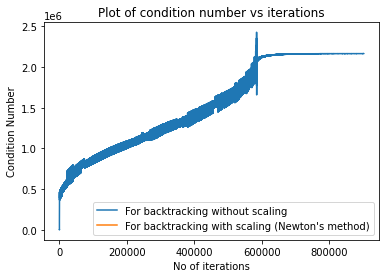

In [22]:
#we will plot the function values and check the behavior
plt.plot(cond_no, label = 'For backtracking without scaling')
plt.plot(cond_no_scaling, label = "For backtracking with scaling (Newton's method)")
plt.xlabel('No of iterations')
plt.ylabel('Condition Number')
plt.title("Plot of condition number vs iterations")
plt.legend()
plt.show()

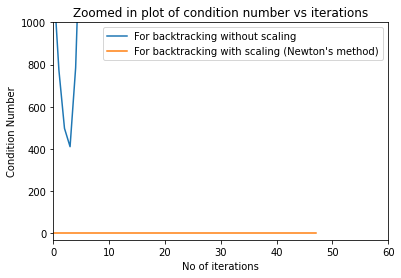

In [23]:
#we will plot the function values and check the behavior
plt.plot(cond_no, label = 'For backtracking without scaling')
plt.plot(cond_no_scaling, label = "For backtracking with scaling (Newton's method)")
plt.xlabel('No of iterations')
plt.ylabel('Condition Number')
plt.xlim(0, 60)
plt.ylim(-30,1000)
plt.title("Zoomed in plot of condition number vs iterations")
plt.legend()
plt.show()

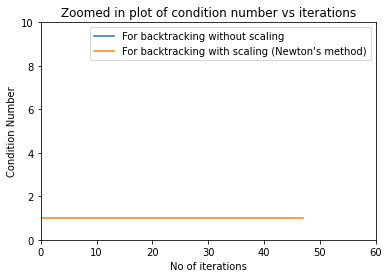

In [24]:
#we will plot the function values and check the behavior
plt.plot(cond_no, label = 'For backtracking without scaling')
plt.plot(cond_no_scaling, label = "For backtracking with scaling (Newton's method)")
plt.xlabel('No of iterations')
plt.ylabel('Condition Number')
plt.xlim(0, 60)
plt.ylim(0,10)
plt.title("Zoomed in plot of condition number vs iterations")
plt.legend()
plt.show()

Answer 1) 
Assuming $\mathbf{D}^k$ to be a diagonal matrix, we can take $\mathbf{D}^k$ to be the diagonal approximation of the inverse of $\nabla^2 f(\mathbf{x})$ (Hessian of the function f(X)) which gives us:

$\begin{aligned}
\mathbf{D}^k = \begin{bmatrix} \frac{1}{f_{x_1 x_1}} & 0\\ 0 & \frac{1}{f_{x_2 x_2}} \end{bmatrix}
\end{aligned}
$ where $f_{x_1 x_1} = \frac{\partial^2f(\mathbf{x})}{\partial x_1^2}$ and  $f_{x_2 x_2} = \frac{\partial^2f(\mathbf{x})}{\partial x_2^2}$

Based on our given function, the matrix $\mathbf{D}^k$ comes out to be $\begin{bmatrix} \frac{1}{f_{x_1 x_1}} & 0\\ 0 & \frac{1}{f_{x_2 x_2}} \end{bmatrix}$, where $f_{x_1 x_1} = (-2048x_2 + 6144 x_1^2 +2)$, and $f_{x_2 x_2} = 1024$

**Gradient descent with backtracking line search without scaling**

Minimizer = [ 3.99995978 15.99967823]

Minimum function value = 1.6177657790688166e-09

No of iterations = 902400

**Gradient descent with backtracking line search with scaling (Diagonal approximation)**

Minimizer = [ 4.00000993 16.0000794 ]

Minimum function value = 9.850897480037126e-11

No of iterations = 904703

**Observations:**
In both the cases, the minimizer is close to [0,0] and the minimum function value is close to 0. Here, gradient descent with backtracking line search with scaling (diagonal approximation) takes more number of iterations than gradient descent with backtracking line search without scaling.

Answer 3) The matrix Q whose condition number needs to be analyzed can be taken to be $\mathbf{M}^\top \nabla^2f(x^k) \mathbf{M}$ where $\nabla^2f(x)$ is the Hessian of the function f(x) and $\mathbf{M} = \mathbf{(D^k)}^{\frac{1}{2}}$. The choice of $\mathbf{D^k}$ (the scaling matrix) is $(\nabla^2f(\textbf{x}^k))^{-1}$.

Answer 4) 

**Gradient descent with backtracking line search without scaling**

Minimizer = [ 3.99995978 15.99967823]

Minimum function value = 1.6177657790688166e-09

No of iterations = 902400

**Gradient descent with backtracking line search with scaling (Newton's method)**

Minimizer = [ 4. 16.]

Minimum function value = 2.373469471365615e-25

No of iterations = 48

**Observations:** 

In both the cases, the minimizer is close to [0,0] and the minimum function value is close to 0. Here, gradient descent with backtracking line search with scaling (Newton's method) takes very less number of iterations and gives better result than gradient descent with backtracking line search without scaling. 

In backtracking line search without scaling, the condition numbers tend to be very high and they generally increase with increase in number of iterations. But, in backtracking line search with scaling (Newton's method), the condition numbers come out to be very close to 1.